<h1 style="color: green">Beijing Air Quality Data (2010-15)</h1>
<h1 style="font-size:32px;">TIME SERIES MODEL (SARIMAX)</h1>

<hr>

## Table of Contents
* [1. Data Transformation](#dtransf)
    * [1.1 Convert to Time Series](#dtransf_ts)
    * [1.2 Seasonal Variation / Trend Decomposition](#dtransf_st)
    * [1.3 Discard Not Needed / Convert Categorical](#dtransf_etc)
    * [1.4 Normalize High Variance Variables](#dtransf_norm)
* [2. SARIMAX Model](#sarimax)
    * [2.1 First-Pass Model](#sarimax_1)
    * [2.2 Final Model](#sarimax_2)
* [3. Results](#results)
        
<hr>

#### Load Modeled Data & Modules

In [536]:
import pandas as pd
import numpy as np
%matplotlib inline
from datetime import datetime
from sklearn.preprocessing import RobustScaler, quantile_transform
from sklearn.model_selection import KFold

In [537]:
beijing = pd.read_csv("beijing.csv")
beijing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43824 entries, 0 to 43823
Data columns (total 14 columns):
No             43824 non-null int64
year           43824 non-null int64
month          43824 non-null int64
day            43824 non-null int64
hour           43824 non-null int64
pm2.5          41757 non-null float64
DEWP           43824 non-null int64
TEMP           43824 non-null float64
PRES           43824 non-null float64
cbwd           43824 non-null object
Iws            43824 non-null float64
Is             43824 non-null int64
Ir             43824 non-null int64
model_pm2.5    43824 non-null float64
dtypes: float64(5), int64(8), object(1)
memory usage: 4.7+ MB


# 1. Data Transformations <a class="anchor" id="dtransf"></a>
## 1.1 Convert to Time Series <a class="anchor" id="dtransf_ts"></a>

In [538]:
# Convert to Datetime
def dmy2datetime(x):
    s = "{day:02d}-{month:02d}-{year:04d} {hour:02d}".format(**x)
    return pd.to_datetime(s,format="%d-%m-%Y %H")
beijing.index = pd.Index(beijing.apply(dmy2datetime , axis=1),name="day_hour")

#### Work With Daily Values (Recorded at Noon)

In [539]:
midn = beijing.iloc[12::24,:].copy()

#### Take 1st Difference of Dependent Variable (Particulate Matter 2.5 Level)

In [540]:
midn['log_diff_pm'] = np.log1p(midn["model_pm2.5"]).diff()

In [541]:
midn = midn.dropna()

## 1.2 Seasonal Variation / Trend Decomposition <a class="anchor" id="dtransf_st"></a>
Not Performed

- In principle there is yearly cycle, but only 5 cycles are observed.

No Clear Seasonal Effect


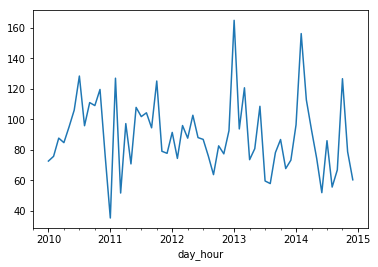

In [542]:
print("No Clear Seasonal Effect")
ax = midn['pm2.5'].resample('M').mean().plot()

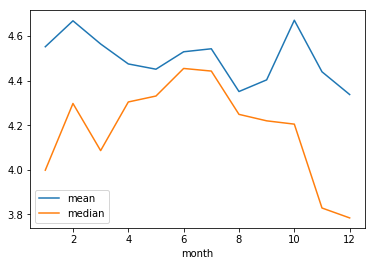

In [543]:
ax = midn.groupby('month')['pm2.5'].agg(['mean','median']).apply(lambda x: np.log1p(x),axis=1).plot()

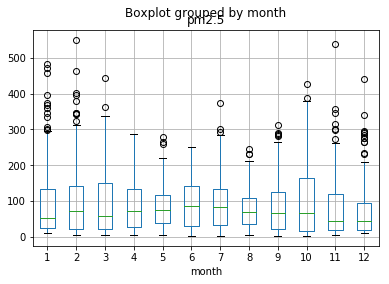

In [544]:
ax = midn.boxplot('pm2.5',by='month')

## 1.3 Discard Not Needed /  Convert Categorical<a class="anchor" id="dtransf_etc"></a>

In [545]:
# Drop Unwanted
midn.drop(["No","year","month","day","hour","pm2.5"], inplace=True, axis=1)

In [546]:
# Convert Category to One-Hot
midn = pd.get_dummies(midn)
midn.head()

,DEWP,TEMP,PRES,Iws,Is,Ir,model_pm2.5,log_diff_pm,cbwd_NE,cbwd_NW,cbwd_SE,cbwd_cv
day_hour,,,,,,,,,,,,
2010-01-02 12:00:00,-8,-5.0,1026.0,23.69,0,0,148.0,1.499601,0,0,1,0
2010-01-03 12:00:00,-11,-9.0,1021.0,105.93,17,0,107.0,-0.321815,0,0,1,0
2010-01-04 12:00:00,-21,-11.0,1030.0,117.55,0,0,29.0,-1.280934,0,1,0,0
2010-01-05 12:00:00,-25,-12.0,1034.0,39.35,0,0,27.0,-0.068993,1,0,0,0
2010-01-06 12:00:00,-24,-10.0,1034.0,59.00,0,0,28.0,0.035091,1,0,0,0


## 1.4 Normalize High Variance Variables<a class="anchor" id="dtransf_norm"></a>
#### Dependent Variable

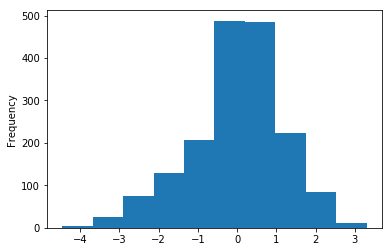

In [547]:
ax = midn['log_diff_pm'].plot.hist()

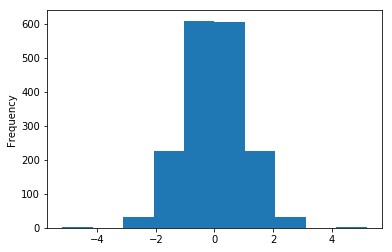

In [548]:
def fn(x):
    a = x.reshape([-1,1]).copy()
    # Expect flat numpy array
    y = quantile_transform(a, output_distribution='normal', random_state = 19)
    return y.flatten()
ax = pd.Series(fn(midn['log_diff_pm'].values)).plot.hist()

In [549]:
midn['log_diff_pm_norm'] = fn(midn['log_diff_pm'].values)

#### Dew Point, Temperature, Pressure

In [550]:
midn['temp_near_dewp'] = (np.abs(midn["TEMP"]-midn["DEWP"]) < 3).astype('int')

vars = ['DEWP','TEMP','PRES']
midn[vars] = midn[vars].apply(lambda x: (x-x.mean())/x.std())

#### Wind Speed, Snowfall, Rainfall

In [551]:
vars = ['Iws','Is','Ir']
#midn[vars] = midn[vars].apply(np.sqrt)

# Use Indicator Variables for Zero or Low Level
midn['No Snow'] = (midn['Is'] < .001).astype('int')
midn['No Rain'] = (midn['Ir'] < .001).astype('int')
midn['No Wind'] = (midn['Iws'] < 1.0).astype('int')

In [552]:
cbwd = ['cbwd_NW', 'cbwd_NE', 'cbwd_SE', 'cbwd_cv']
midn.groupby(cbwd + ['No Wind']).size().unstack()

No Wind                            0    1
cbwd_NW cbwd_NE cbwd_SE cbwd_cv          
0       0       0       1        341  120
                1       0        540    1
        1       0       0        189    2
1       0       0       0        537    1

# 2. SARIMAX Model<a class="anchor" id="sarimax"></a>
#### Measurements at Midnight Only

In [553]:
midn_norm = midn.drop('model_pm2.5', axis=1).astype('float')

In [554]:
midn_norm.describe()

,DEWP,TEMP,PRES,Iws,Is,Ir,log_diff_pm,cbwd_NE,cbwd_NW,cbwd_SE,cbwd_cv,log_diff_pm_norm,temp_near_dewp,No Snow,No Rain,No Wind
count,1.731000e+03,1.731000e+03,1.731000e+03,1731.000000,1731.000000,1731.000000,1731.000000,1731.000000,1731.000000,1731.000000,1731.000000,1731.000000,1731.000000,1731.000000,1731.000000,1731.000000
mean,-5.746735e-17,6.567697e-17,2.824110e-15,22.400179,0.085500,0.192374,0.000509,0.110341,0.310803,0.312536,0.266320,-0.000050,0.041594,0.989601,0.963027,0.071635
std,1.000000e+00,1.000000e+00,1.000000e+00,48.624169,0.942063,1.397549,1.179001,0.313405,0.462956,0.463661,0.442161,1.010961,0.199718,0.101471,0.188750,0.257957
min,-2.495598e+00,-2.382266e+00,-2.217933e+00,0.450000,0.000000,0.000000,-4.452019,0.000000,0.000000,0.000000,0.000000,-5.199338,0.000000,0.000000,0.000000,0.000000
25%,-8.702846e-01,-9.363972e-01,-8.509596e-01,1.790000,0.000000,0.000000,-0.587787,0.000000,0.000000,0.000000,0.000000,-0.673702,0.000000,1.000000,1.000000,0.000000
50%,-5.762775e-02,1.692669e-01,2.780877e-02,4.920000,0.000000,0.000000,0.133531,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
75%,9.581933e-01,9.347266e-01,8.089362e-01,18.775000,0.000000,0.000000,0.731822,0.000000,1.000000,1.000000,1.000000,0.675143,0.000000,1.000000,1.000000,0.000000
max,1.770850e+00,1.955340e+00,2.664114e+00,468.050000,17.000000,27.000000,3.301114,1.000000,1.000000,1.000000,1.000000,5.199338,1.000000,1.000000,1.000000,1.000000


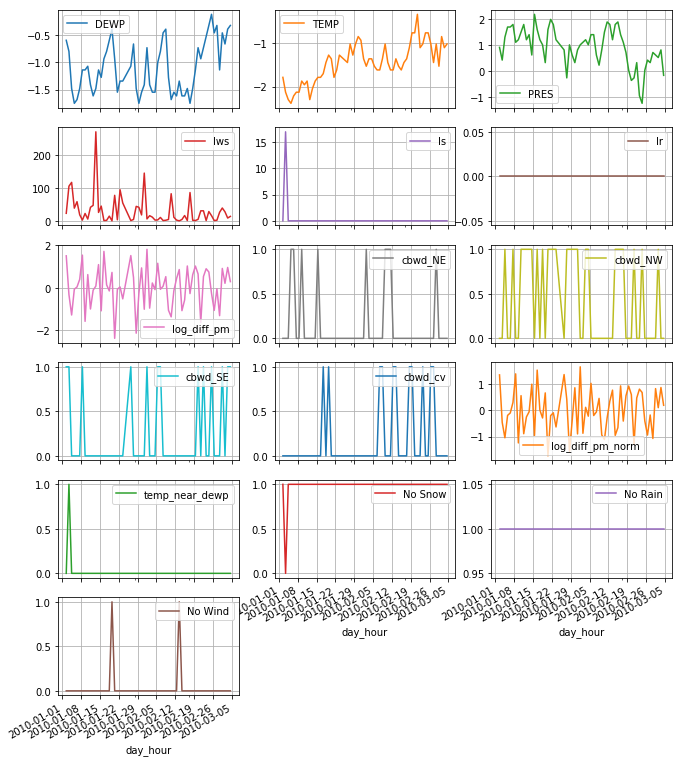

In [555]:
ax = midn_norm.iloc[:60,:].plot(subplots=True,figsize=(11,14),grid=True,layout=(6,3))

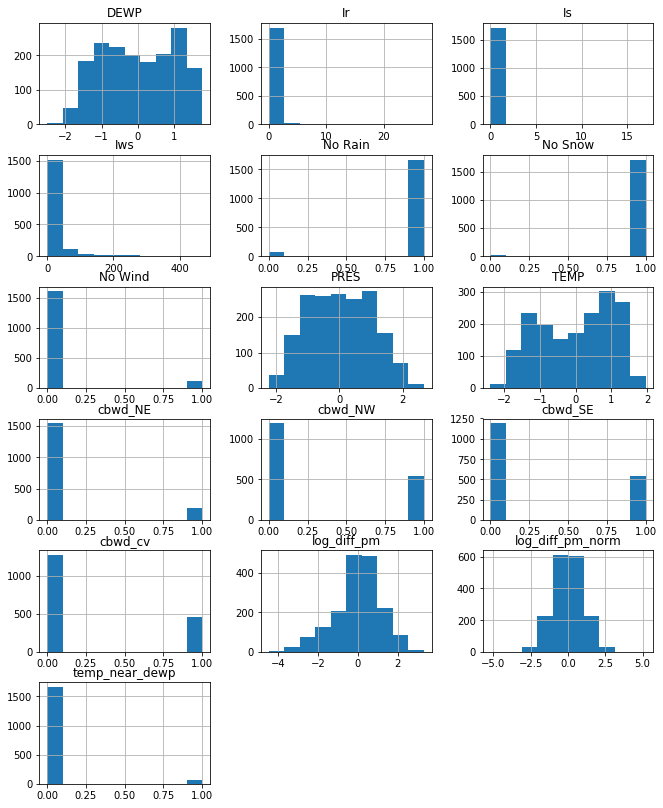

In [556]:
ax = midn_norm.hist(figsize=(11,14),grid=True,layout=(6,3))

## 2.1 First-Pass Model<a class="anchor" id="sarimax_1"></a>

In [557]:
from statsmodels.tsa.api import SARIMAX

exog_vars0 = ['DEWP', 'TEMP', 'PRES', 'No Rain', 'No Snow', 'Iws', 'cbwd_NW', 
             'cbwd_SE', 'No Wind', 'cbwd_NE', 'Ir', 'Is', 'temp_near_dewp']


model = SARIMAX(endog=midn_norm["log_diff_pm"], exog = midn_norm[exog_vars0], order = (1,0,1))

In [558]:
results = model.fit(maxiter = 200, method='powell')
results.summary()

Optimization terminated successfully.
         Current function value: 1.403571
         Iterations: 7
         Function evaluations: 1115


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:            log_diff_pm   No. Observations:                 1731
Model:               SARIMAX(1, 0, 1)   Log Likelihood               -2429.581
Date:                Fri, 08 Feb 2019   AIC                           4891.162
Time:                        12:38:48   BIC                           4978.465
Sample:                    01-02-2010   HQIC                          4923.452
                         - 12-31-2014                                         
Covariance Type:                  opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
DEWP               0.0539      0.030      1.775      0.076      -0.006       0.113
TEMP              -0.1200      0.034     -3.525      0.000      -0.187      -0.053
PRES               0.0158      0.024      0.674      0.501      -0.030       0.062
No Rain           -0.1457      0.161     -0.906      0.365      -0.461       0.170
No Snow            0.3744      0.166      2.260      0.024       0.050       0.699
Iws               -0.0011      0.000     -2.278      0.023      -0.002      -0.000
cbwd_NW           -0.4223      0.064     -6.630      0.000      -0.547      -0.297
cbwd_SE            0.0630      0.062      1.014      0.311      -0.059       0.185
No Wind           -0.0247      0.088     -0.282      0.778      -0.197       0.147
cbwd_NE           -0.6632      0.073     -9.033      0.000      -0.807      -0.519
Ir                -0.0490      0.027     -1.830      0.067      -0.102       0.003
Is                 0.0014      0.030      0.046      0.963      -0.058       0.061
temp_near_dewp    -0.2250      0.124     -1.808      0.071      -0.469       0.019
ar.L1              0.3054      0.042      7.311      0.000       0.224       0.387
ma.L1             -0.7410      0.028    -26.567      0.000      -0.796      -0.686
sigma2             0.9700      0.031     31.073      0.000       0.909       1.031
===================================================================================
Ljung-Box (Q):                       44.52   Jarque-Bera (JB):               110.81
Prob(Q):                              0.29   Prob(JB):                         0.00
Heteroskedasticity (H):               1.15   Skew:                            -0.54
Prob(H) (two-sided):                  0.09   Kurtosis:                         3.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

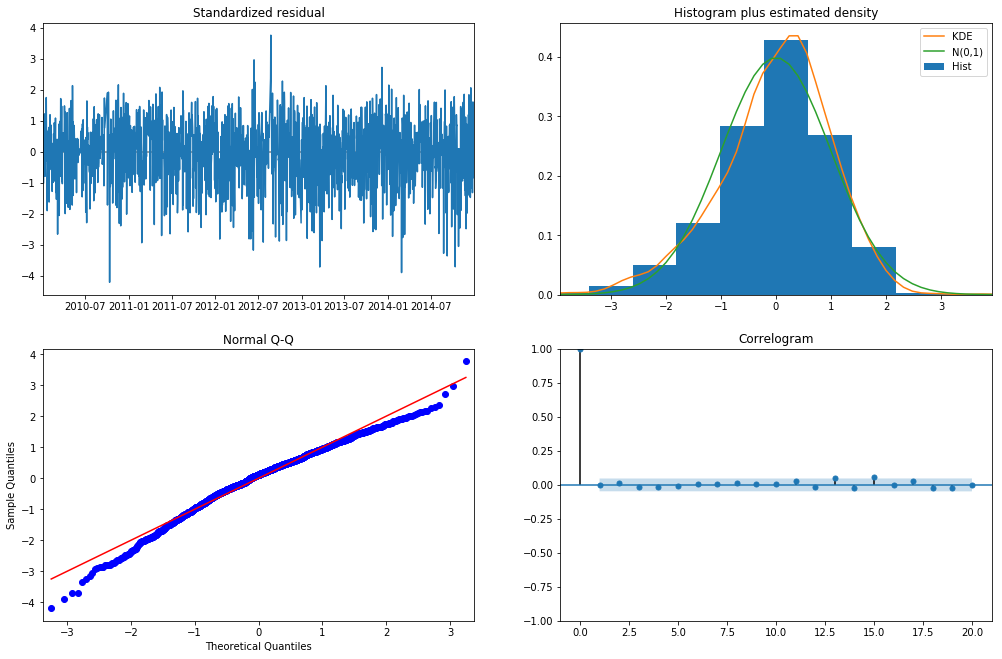

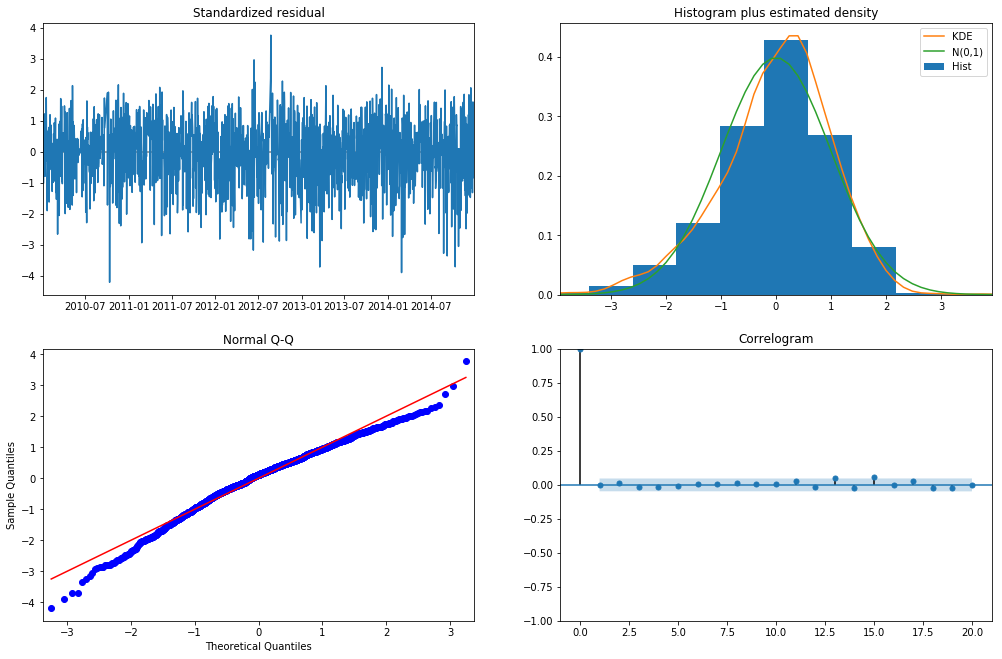

In [559]:
results.plot_diagnostics(lags = 20, figsize = (17,11))

## 2.2 Final Model<a class="anchor" id="sarimax_2"></a>

In [560]:
X = midn_norm.drop(["PRES","Is","No Rain","No Wind"],axis=1)
exog_vars1 = [col for col in exog_vars0 if col in X.columns]
model = SARIMAX(X["log_diff_pm_norm"], exog = X[exog_vars1], order = (1,0,1))

In [561]:
results = model.fit(maxiter=200, method = 'powell')
results.summary()

Optimization terminated successfully.
         Current function value: 1.257991
         Iterations: 6
         Function evaluations: 742


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:       log_diff_pm_norm   No. Observations:                 1731
Model:               SARIMAX(1, 0, 1)   Log Likelihood               -2177.583
Date:                Fri, 08 Feb 2019   AIC                           4379.165
Time:                        12:38:51   BIC                           4444.643
Sample:                    01-02-2010   HQIC                          4403.383
                         - 12-31-2014                                         
Covariance Type:                  opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
DEWP               0.0254      0.028      0.917      0.359      -0.029       0.080
TEMP              -0.1139      0.025     -4.469      0.000      -0.164      -0.064
No Snow            0.2095      0.030      7.051      0.000       0.151       0.268
Iws               -0.0013      0.000     -3.246      0.001      -0.002      -0.001
cbwd_NW           -0.3853      0.051     -7.604      0.000      -0.485      -0.286
cbwd_SE            0.0627      0.047      1.329      0.184      -0.030       0.155
cbwd_NE           -0.5626      0.060     -9.330      0.000      -0.681      -0.444
Ir                -0.0254      0.019     -1.340      0.180      -0.063       0.012
temp_near_dewp    -0.2306      0.107     -2.161      0.031      -0.440      -0.021
ar.L1              0.2745      0.045      6.041      0.000       0.185       0.364
ma.L1             -0.6943      0.033    -20.768      0.000      -0.760      -0.629
sigma2             0.7252      0.021     35.044      0.000       0.685       0.766
===================================================================================
Ljung-Box (Q):                       41.83   Jarque-Bera (JB):                67.00
Prob(Q):                              0.39   Prob(JB):                         0.00
Heteroskedasticity (H):               1.10   Skew:                            -0.08
Prob(H) (two-sided):                  0.25   Kurtosis:                         3.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

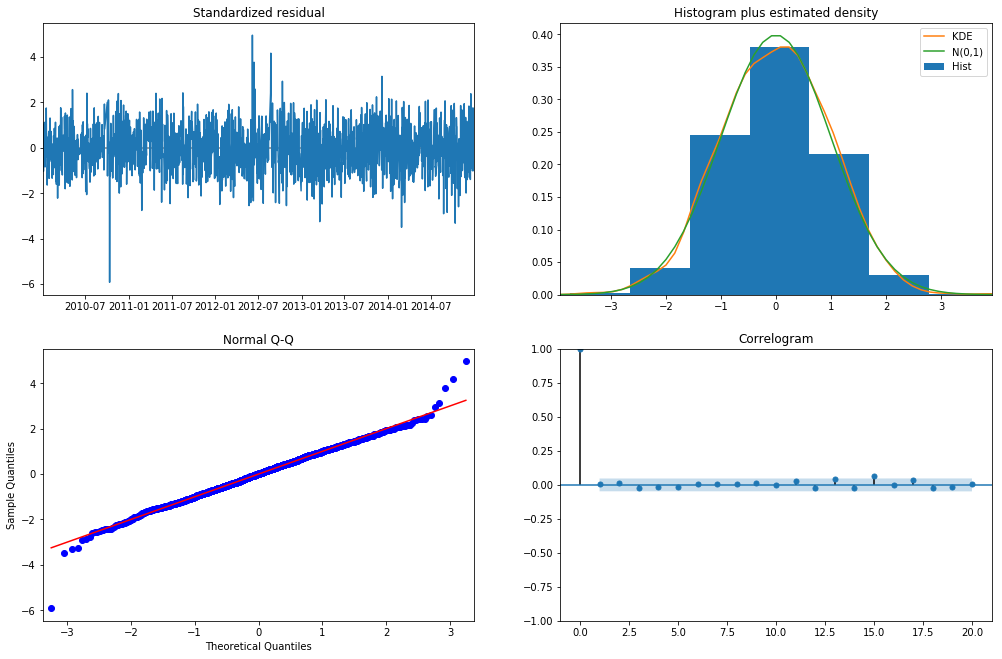

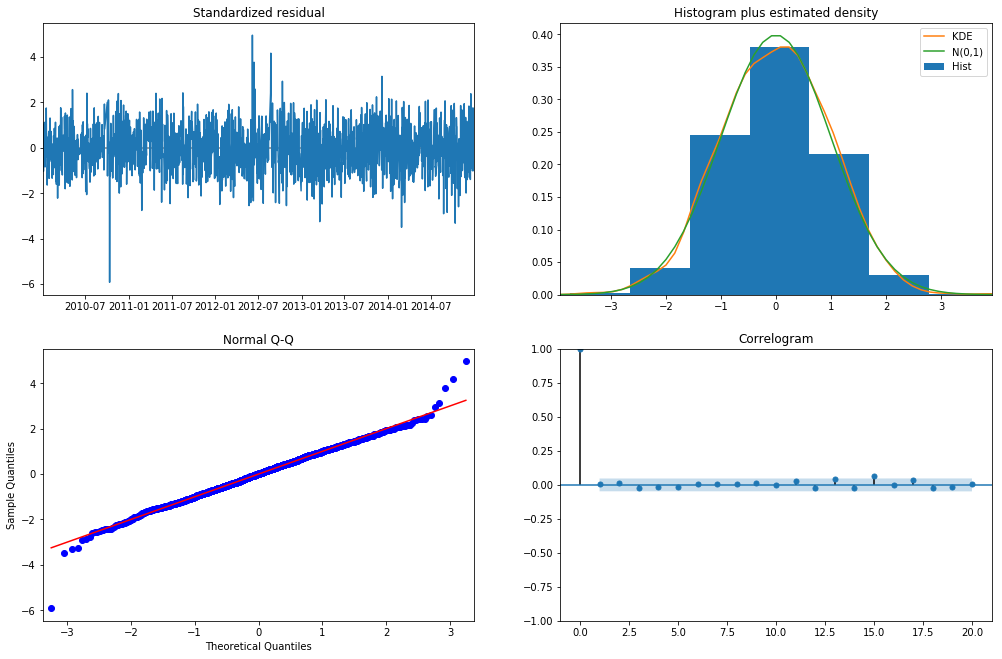

In [562]:
results.plot_diagnostics(lags = 20, figsize = (17,11))

### SPECIFICATION TESTS
* Residual Autocorrelation : PASS
* Heteroschedasticity: PASS
* Normality: Residuals Mostly Normal, but With Big Outliers on Both Sides

# 3. RESULTS<a class="anchor" id="results"></a>

#### POSITIVE EFFECTS ON RATE OF GROWTH
* No Snow

#### NEGATIVE EFFECTS ON RATE OF GROWTH
* Temperature
* Temperature close to Dew Point
* Wind Speed
* Winds from NW or NE